# Project 2 (Predicting Sales for E-Commerce)

This notebook demonstrates the application of supervised machine learning techniques to an e-commerce transactional dataset, focusing on:

1) Data preparation and feature construction for modelling
2) Training and comparing regression-based models
3) Model evaluation using standard performance metrics

## Import libraries and Data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

In [20]:
df = pd.read_csv("/content/OnlineRetail.csv", encoding="latin", dtype={'CustomerID': str})

In [21]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


- Just by looking at the first 5 rows of our table, I can understand the structure and datatypes present in the dataset.
- I can notice that I will have to deal with time series data, integers and floats, and categorical, and text data.

## Exploratory Data Analysis(EDA)
- Every data science project starts with EDA as I have to understand what do I have to deal with.
- I divide EDA into 2 types: visual and numerical. Let's start with numerical as the simple pandas method .describe() gives me a lot of useful information.

## Quick statistical overview

In [22]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


- Just a quick look at data with the .describe() method gives us a lot of space to think.
- I see negative quantities and prices, and I can see that not all records have CustomerID data.
- I can also see that the majority of transactions are for quantities from 3 to 10 items, majority of items have prices up to 5 pounds.
- I have a bunch of huge outliers I will have to deal with later.

## Dealing with types
- .read_csv() method performs basic type check, but it doesn't do that perfectly.
- That's why it is much better to deal with data types in the dataframe before any modifications to prevent additional difficulties.
- Every pandas dataframe has an attribute .dtypes which will help me understand what I currently have and what data has to be casted to correct types.

In [23]:
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,object
Country,object


- If I have DateTime data it's better to cast it to DateTime type.
- I don't touch InvoiceNo for now as it seems like data in this column has not only numbers.
- I saw just the first 5 rows, while pandas during import scanned all the data and found that the type here is not numerical.

In [24]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')

In [25]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom


## Dealing with null values
- There are few strategies that I can use to fix the issue with null values:

    - delete rows with null values
    - delete the feature with null values
    - impute data with mean or median values or use another imputing strategy (method .fillna())

In [26]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
UnitPrice,0
CustomerID,135080
Country,0


- CustomerID has too many null values and this feature cannot predict a lot so I can just drop it.
- It could be reasonable to create another feature "Amount of orders per customer".

In [27]:
df = df.drop(columns=['CustomerID'])

## Let's check out what kind of nulls I have in Description:


In [28]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 11:52:00,536414,22139,NaN,56,0.0,United Kingdom
2010-12-01 14:32:00,536545,21134,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536546,22145,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536547,37509,NaN,1,0.0,United Kingdom
2010-12-01 14:34:00,536549,85226A,NaN,1,0.0,United Kingdom


- The data in these rows is pretty strange as UnitPrice is 0, so these orders do not generate any sales.
- I can impute it with "UNKNOWN ITEM" at the moment and deal with those later during the analysis.

In [29]:
df['Description'] = df['Description'].fillna('UNKNOWN ITEM')
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
UnitPrice,0
Country,0


### Checking out columns separately
- It makes sense to go feature by feature and check what pitfalls I have in my data and also to understand the numbers better.

- Let's continue checking the Description column. Here I can see items that were bought most often.

In [30]:
df['Description'].value_counts().head()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2369
REGENCY CAKESTAND 3 TIER,2200
JUMBO BAG RED RETROSPOT,2159
PARTY BUNTING,1727
LUNCH BAG RED RETROSPOT,1638


- Here I can see our best-selling products, items that appear in orders the most often.

# To make it visually more appealing let's create a bar chart for 15 top items

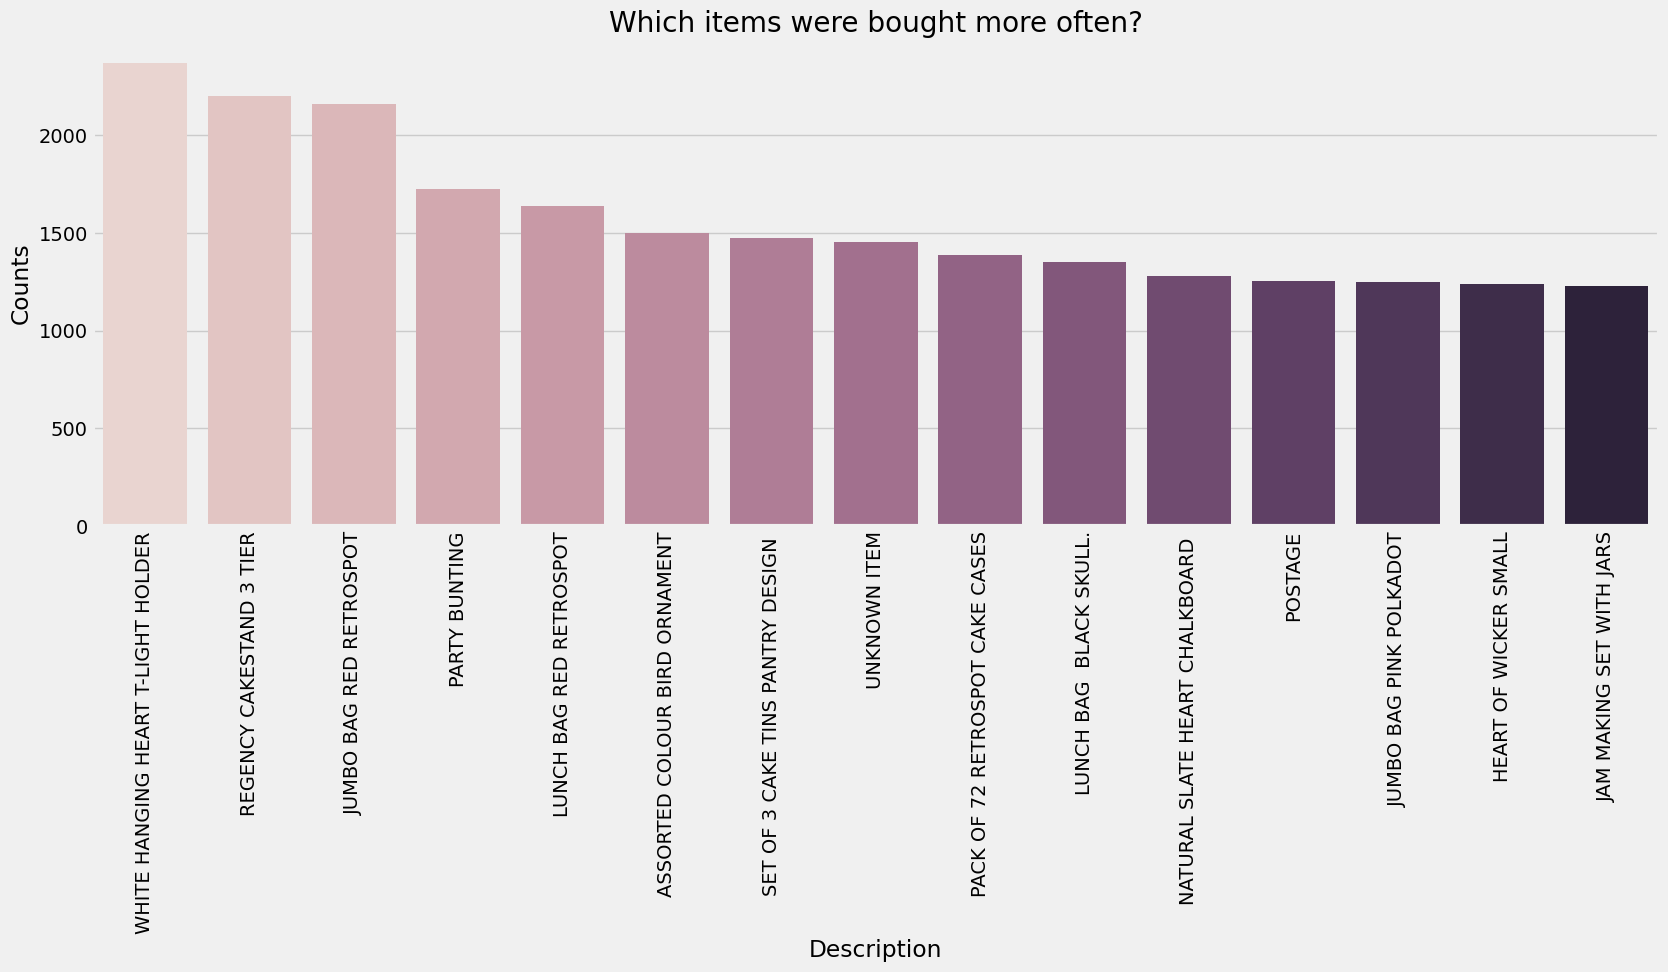

In [31]:
# Which items were bought more often?
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=item_counts.index, y=item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [32]:
df['Description'].value_counts().tail()

,count
Description,
dotcom adjust,1
LARGE HEART FLOWERS HOOK,1
SET 10 CARDS SNOWY ROBIN 17099,1
POLYESTER FILLER PAD 60x40cm,1
mailout,1


- I also notice from the above code that valid items are normally uppercase and non-valid or cancelations are in lowercase.

In [33]:
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

,count
Description,
Manual,572
BAG 125g SWIRLY MARBLES,304
BAG 250g SWIRLY MARBLES,252
3 TRADITIONAl BISCUIT CUTTERS SET,240
POLYESTER FILLER PAD 40x40cm,193


- A quick check of the case of letters in the Description says that there are some units with lowercase letters in their name and also that lowercase records are for canceled items.
- Here I can understand that data management in the store can be improved.

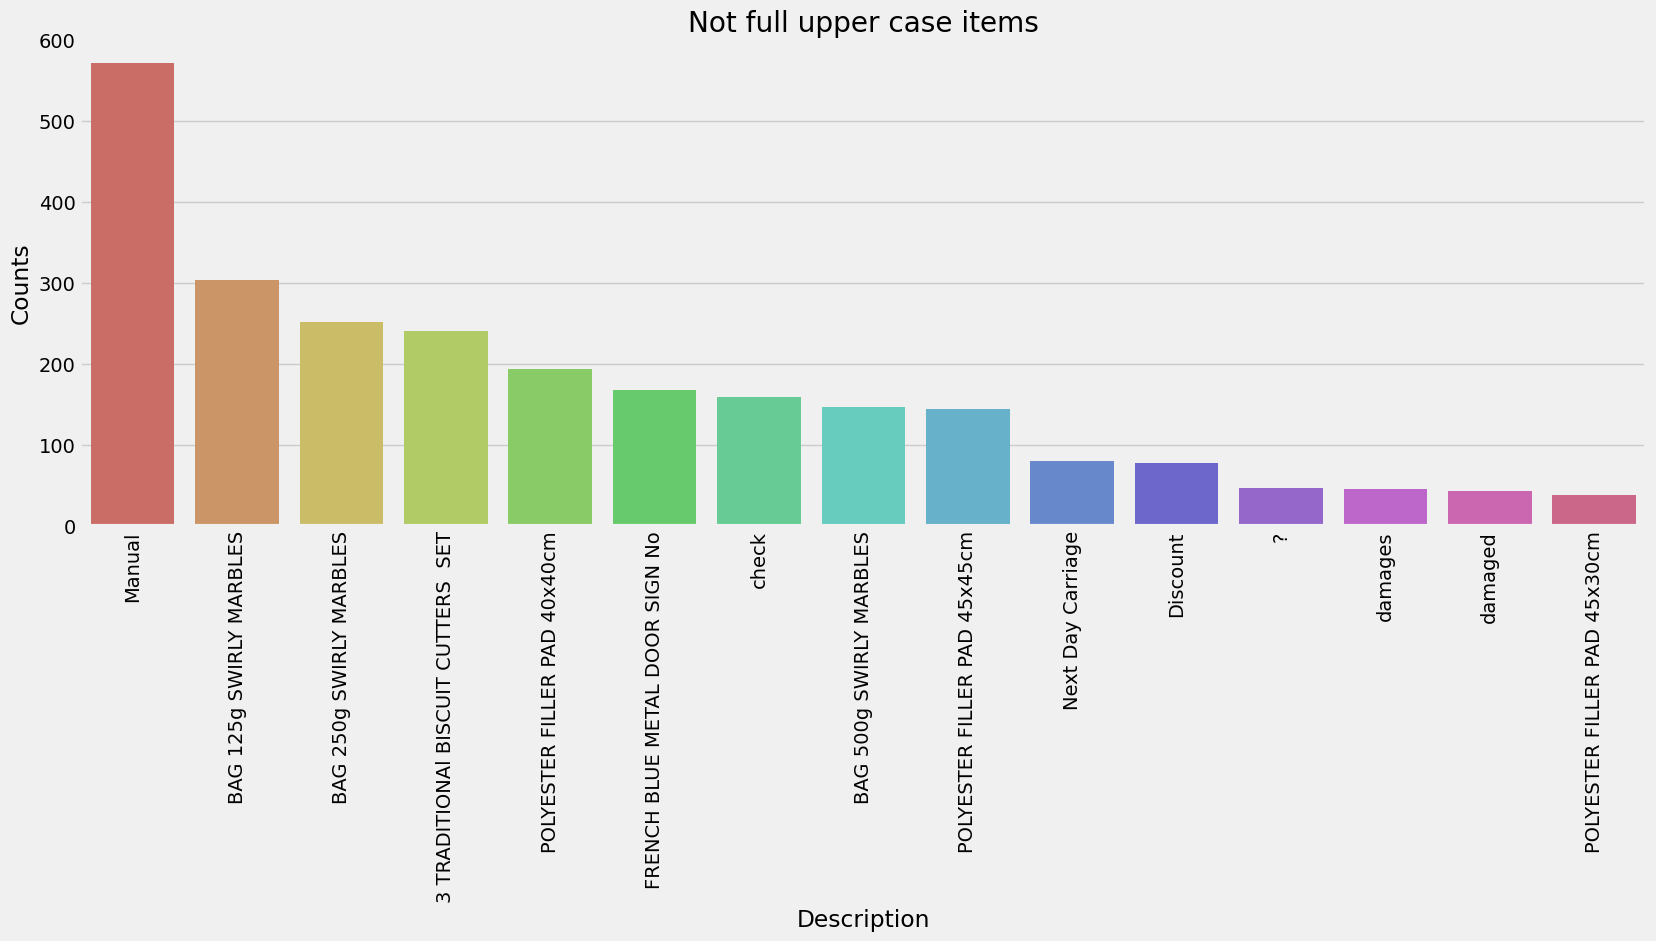

In [34]:
# Not full upper case items
lcase_counts = df[~df['Description'].str.isupper()]['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=lcase_counts.index, y=lcase_counts.values, palette=sns.color_palette("hls", 15))
plt.ylabel("Counts")
plt.title("Not full upper case items");
plt.xticks(rotation=90);

- Checking out stoke codes looks like they are deeply correlated with descriptions - which makes perfect sense.

In [35]:
df['StockCode'].value_counts().head()

,count
StockCode,
85123A,2313
22423,2203
85099B,2159
47566,1727
20725,1639


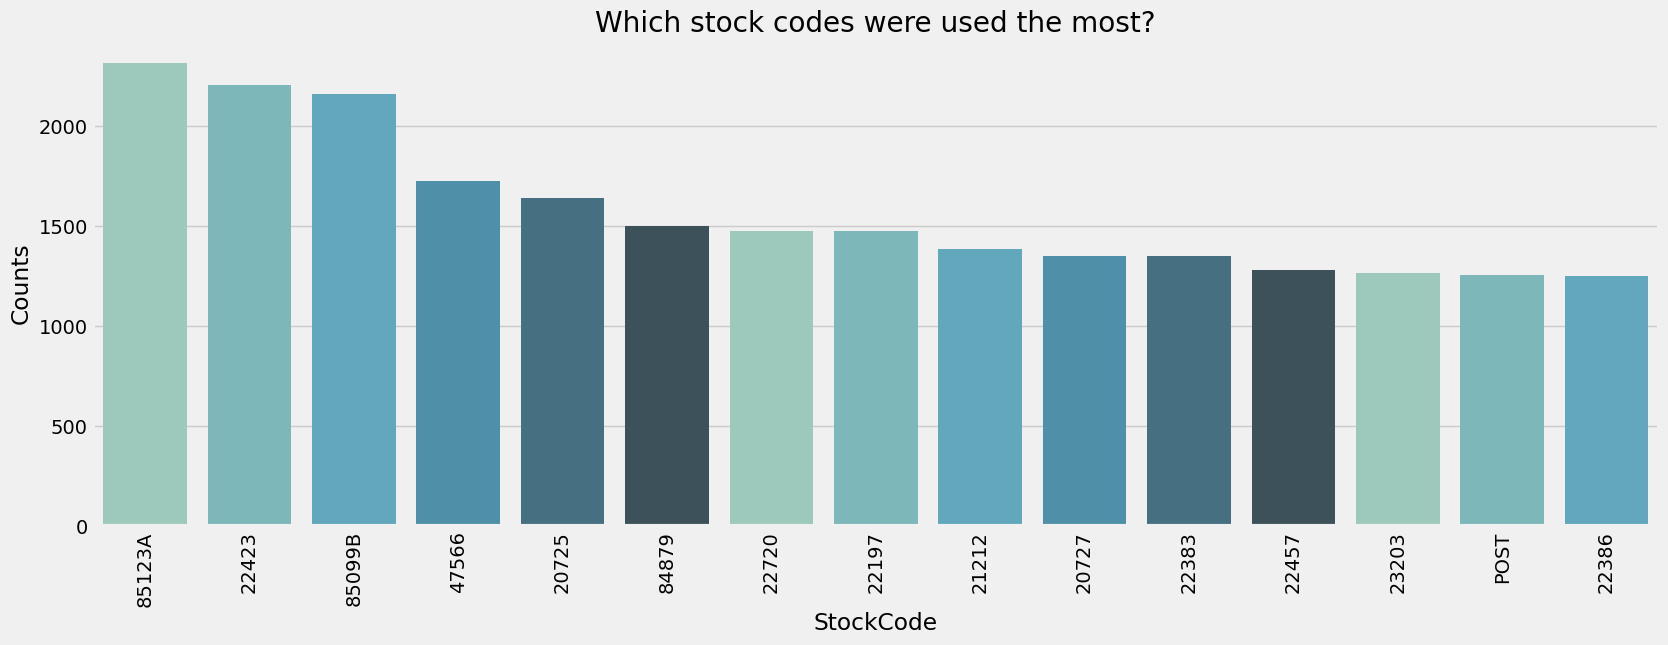

In [36]:
# Which stock codes were used the most?
stock_counts = df['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=stock_counts.index, y=stock_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?");
plt.xticks(rotation=90);

## Checking out also InvoiceNo feature

In [37]:
df['InvoiceNo'].value_counts().tail()

,count
InvoiceNo,
581483,1
581566,1
C581499,1
C536383,1
C536379,1


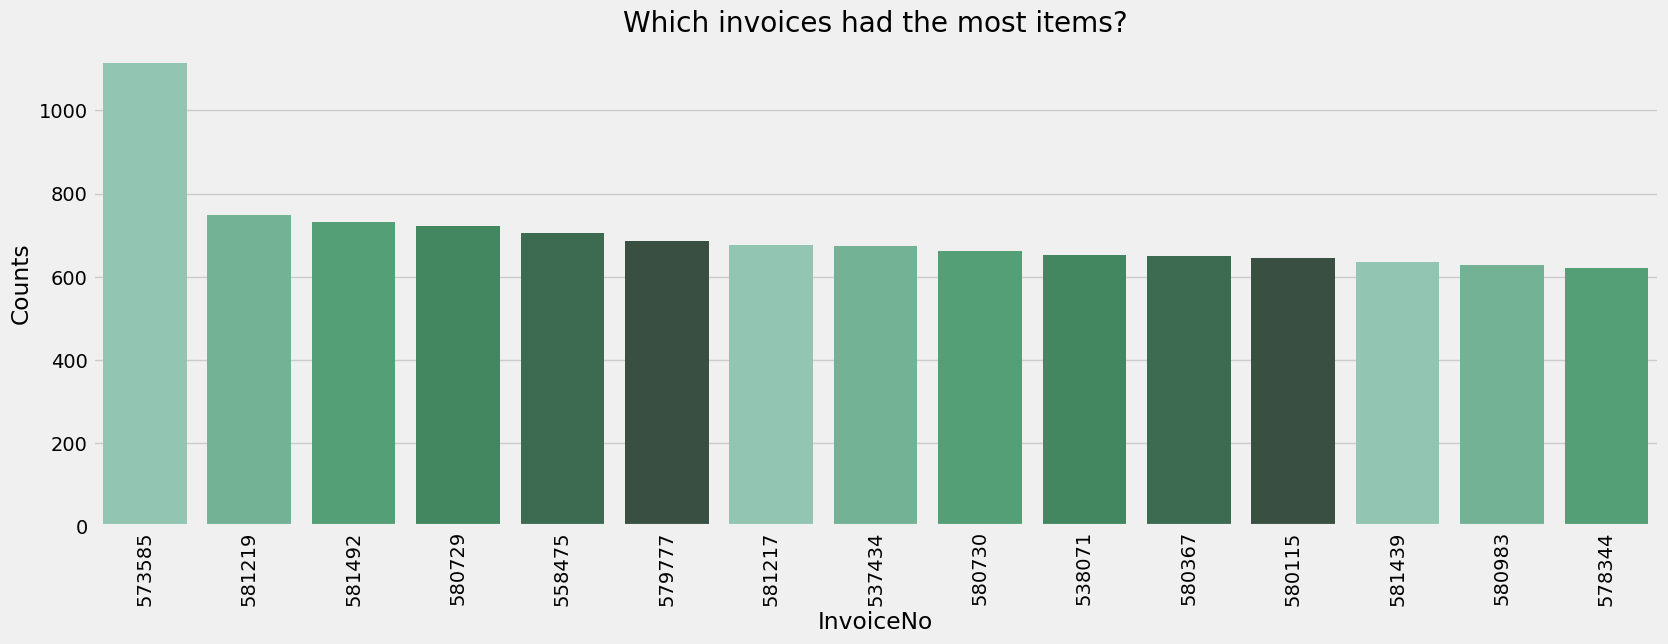

In [38]:
#  Which invoices had the most items?
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=inv_counts.index, y=inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

In [39]:
df[df['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice
count,9288.000000,9288.000000
mean,-29.885228,48.393661
std,1145.786965,666.600430
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


- Looks like Invoices that start with 'C' are the "Canceling"/"Returning" invoices. This resolves the mystery of negative quantities.

- Although, I should've gotten deeper into the analysis of those returns, for the sake of simplicity let's just ignore those values for the moment.

- I can actually start a separate project based on that data and predict the returning/canceling rates for the store.

In [40]:
df = df[~df['InvoiceNo'].str.startswith('C')]

In [41]:
df.describe()

,Quantity,UnitPrice
count,532621.000000,532621.000000
mean,10.239972,3.847621
std,159.593551,41.758023
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- During exploratory data analysis I can go back to the same operations and checks, just to understand how my actions affected the dataset.

- EDA is the series of repetitive tasks to understand better the data.

- Here, for example I get back to .describe() method to get an overall picture of our data after some manipulations.

- I still see negative quantities and negative prices, let's get into those records.

In [42]:
# df[df['Quantity'] < 0]
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 16:50:00,536589,21777,UNKNOWN ITEM,-10,0.0,United Kingdom
2010-12-02 14:42:00,536764,84952C,UNKNOWN ITEM,-38,0.0,United Kingdom
2010-12-03 15:30:00,536996,22712,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536997,22028,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536998,85067,UNKNOWN ITEM,-6,0.0,United Kingdom


- Here I can see that other "Negative quantities" appear to be damaged/lost/unknown items.
- Again, I will just ignore them for the sake of simplicity of analysis for this project.

In [43]:
df = df[df['Quantity'] > 0]
df.describe()

,Quantity,UnitPrice
count,531285.000000,531285.000000
mean,10.655262,3.857296
std,156.830323,41.810047
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- I also see negative UnitPrice, which is not normal as well.
- Let's check this out:

In [44]:
df[df['UnitPrice'] < 0].describe()

,Quantity,UnitPrice
count,2.0,2.00
mean,1.0,-11062.06
std,0.0,0.00
min,1.0,-11062.06
25%,1.0,-11062.06
50%,1.0,-11062.06
75%,1.0,-11062.06
max,1.0,-11062.06


In [45]:
df[df['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2011-08-12 14:51:00,A563186,B,Adjust bad debt,1,-11062.06,United Kingdom
2011-08-12 14:52:00,A563187,B,Adjust bad debt,1,-11062.06,United Kingdom


- As there are just two rows, let's ignore them for the moment (the description gives me enough warnings, although I still need some context to understand it better)

In [46]:
df = df[df['UnitPrice'] > 0]
df.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- As I have finished cleaning our data and removed all suspicious records I can start creating some new features for our model.
- Let's start with the most obvious one - Sales.
- I have quantities and prices - I can calculate the revenue.

## Visual EDA

([0], [Text(0, 0, 'United Kingdom')])

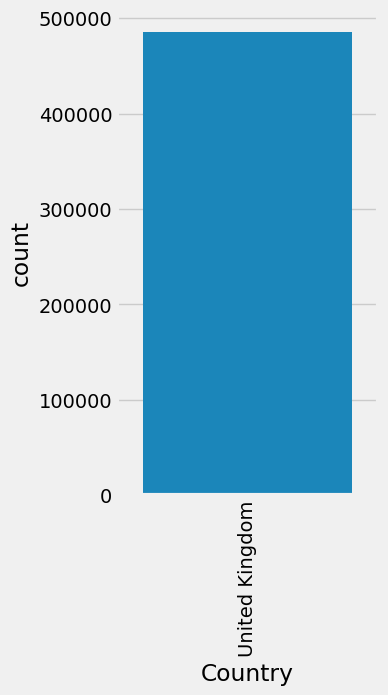

In [47]:
plt.figure(figsize=(3,6))
sns.countplot(x=df[df['Country'] == 'United Kingdom']['Country'])
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 [Text(0, 0, 'France'),
  Text(1, 0, 'Australia'),
  Text(2, 0, 'Netherlands'),
  Text(3, 0, 'Germany'),
  Text(4, 0, 'Norway'),
  Text(5, 0, 'EIRE'),
  Text(6, 0, 'Switzerland'),
  Text(7, 0, 'Spain'),
  Text(8, 0, 'Poland'),
  Text(9, 0, 'Portugal'),
  Text(10, 0, 'Italy'),
  Text(11, 0, 'Belgium'),
  Text(12, 0, 'Lithuania'),
  Text(13, 0, 'Japan'),
  Text(14, 0, 'Iceland'),
  Text(15, 0, 'Channel Islands'),
  Text(16, 0, 'Denmark'),
  Text(17, 0, 'Cyprus'),
  Text(18, 0, 'Sweden'),
  Text(19, 0, 'Finland'),
  Text(20, 0, 'Austria'),
  Text(21, 0, 'Bahrain'),
  Text(22, 0, 'Israel'),
  Text(23, 0, 'Greece'),
  Text(24, 0, 'Hong Kong'),
  Text(25, 0, 'Singapore'),
  Text(26, 0, 'Lebanon'),
  Text(27, 0, 'United Arab Emirates'),
  Text(28, 0, 'Saudi Arabia'),
  Text(29, 0, 'C

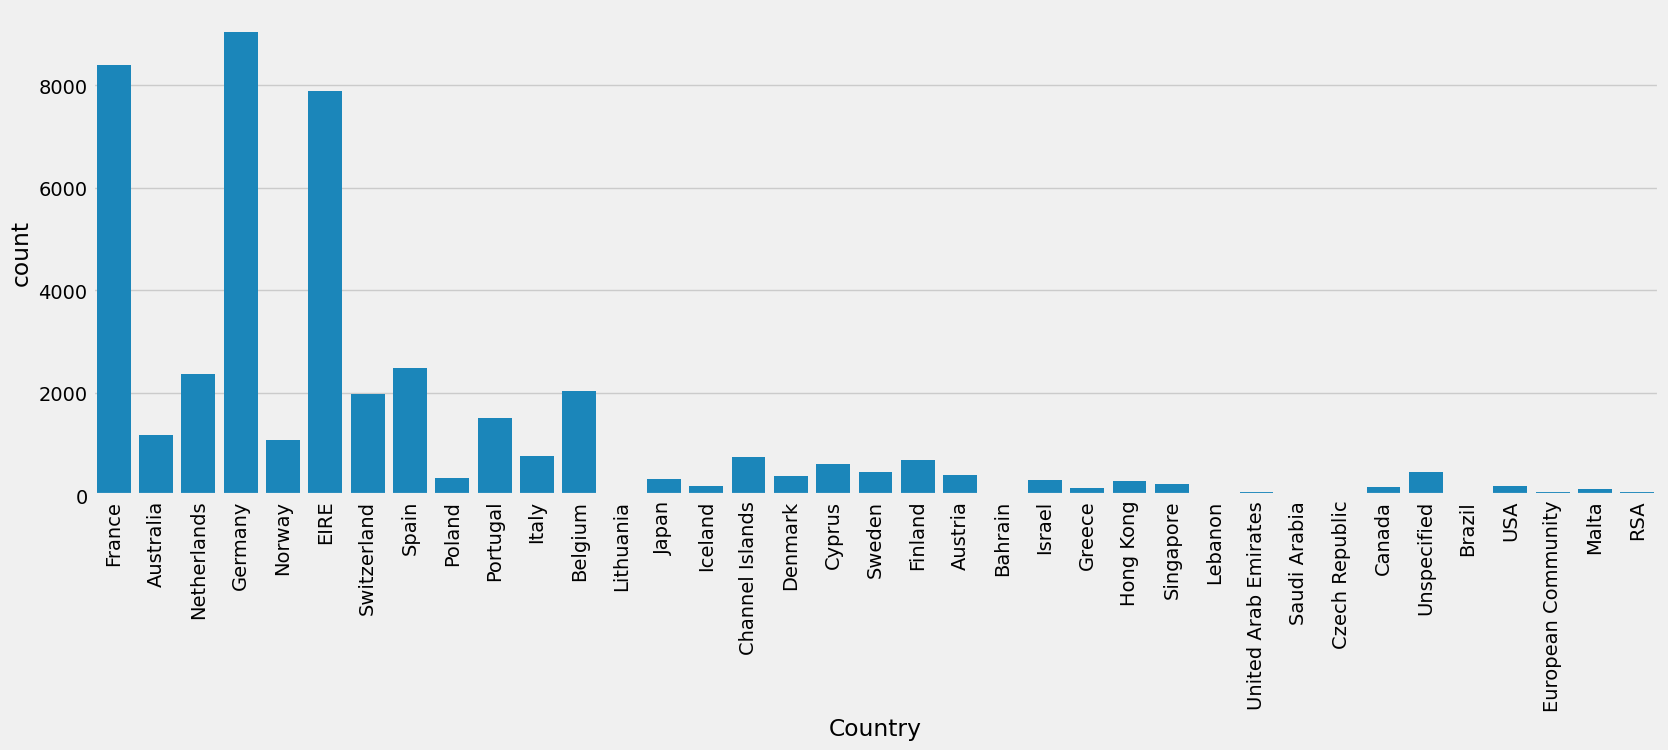

In [48]:
plt.figure(figsize=(18,6))
sns.countplot(x=df[df['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)

In [49]:
uk_count = df[df['Country'] == 'United Kingdom']['Country'].count()
all_count = df['Country'].count()
uk_perc = uk_count/all_count
print(str('{0:.2f}%').format(uk_perc*100))

91.51%


- From the above plots and calculations, I can see that the vast majority of sales were made in the UK and just 8.49% went abroad.
- The dataset is skewed to the UK side.

## Detecting outliers
- There are a few different methods to detect outliers:

    - box plots,
    - using IQR,
    - scatter plot also works in some cases (and this is one of those).

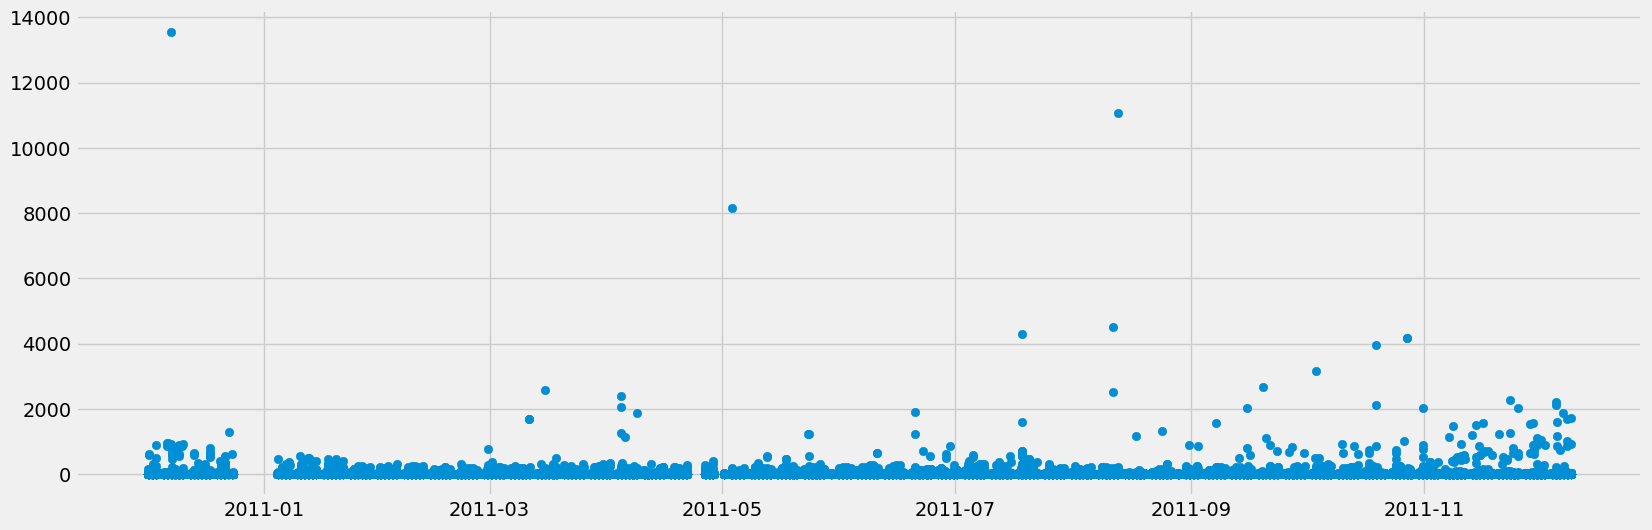

In [50]:
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['UnitPrice'])

## Remove obvious outliers:

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

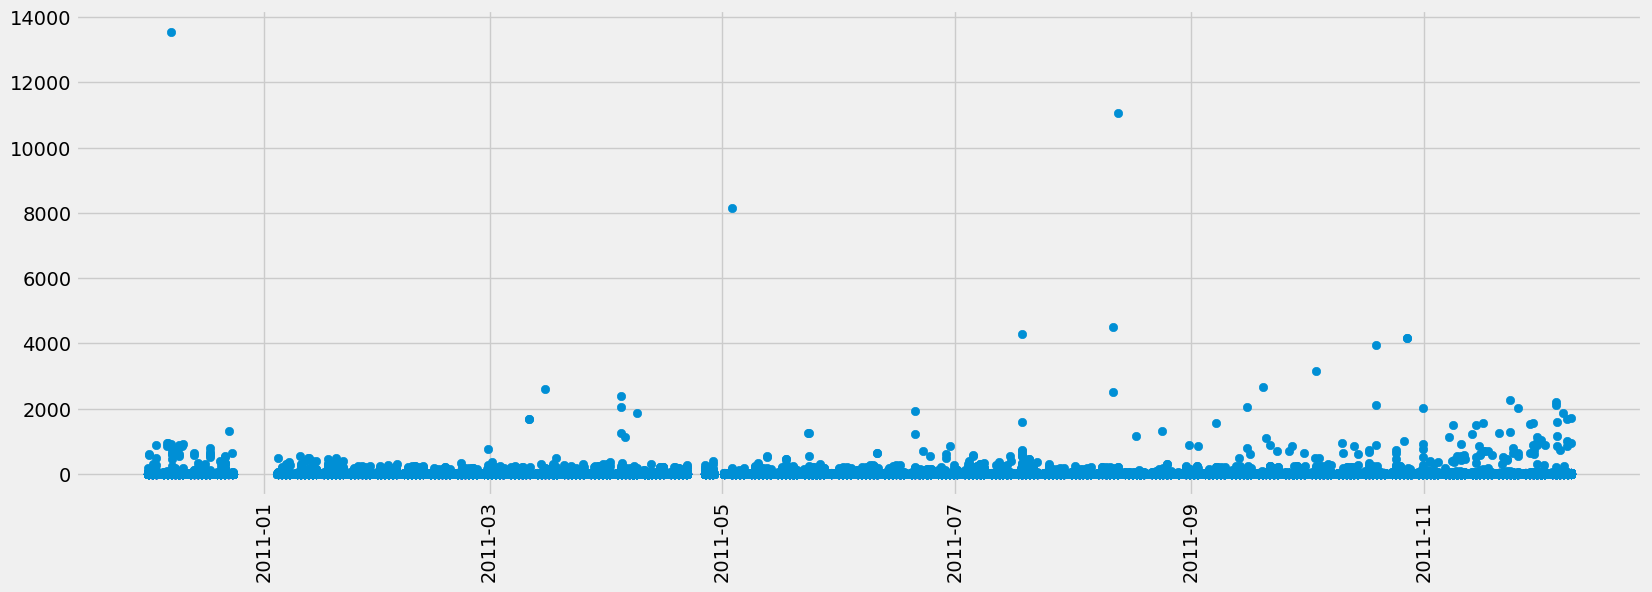

In [51]:
df = df[df['UnitPrice'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['UnitPrice'])
plt.xticks(rotation=90)

- After removing obvious outliers I still see some values that are out of normal distribution.

To understand better the distribution of the data let's check out different percentiles of the numeric features:

In [52]:
df[['Quantity', 'UnitPrice']].quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice
0.050,1.000,0.42
0.950,30.000,9.95
0.980,72.000,14.95
0.990,100.000,16.98
0.999,449.794,165.00


- I can see that if I remove the top 2% of our data points I will get rid of absolute outliers and will have a more balanced dataset.

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

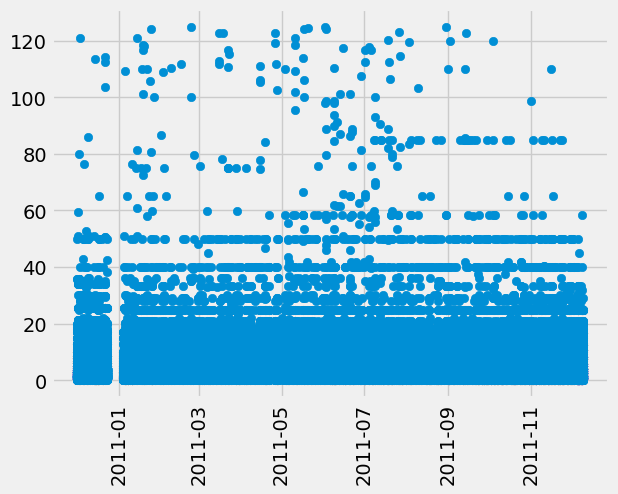

In [53]:
df_quantile = df[df['UnitPrice'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['UnitPrice'])
plt.xticks(rotation=90)

In [54]:
df_quantile.describe()

,Quantity,UnitPrice
count,529361.000000,529361.000000
mean,10.555237,3.306499
std,155.632810,4.006631
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,124.870000


- Looks like the data is almost ready for modelling.
- I performed a clean up, I removed outliers that were disturbing the balance of our dataset, I also removed invalid records.
- Now the data looks much better! and it doesn't lose it's value.

## Visually checking distribution of numeric features

<Axes: ylabel='Density'>

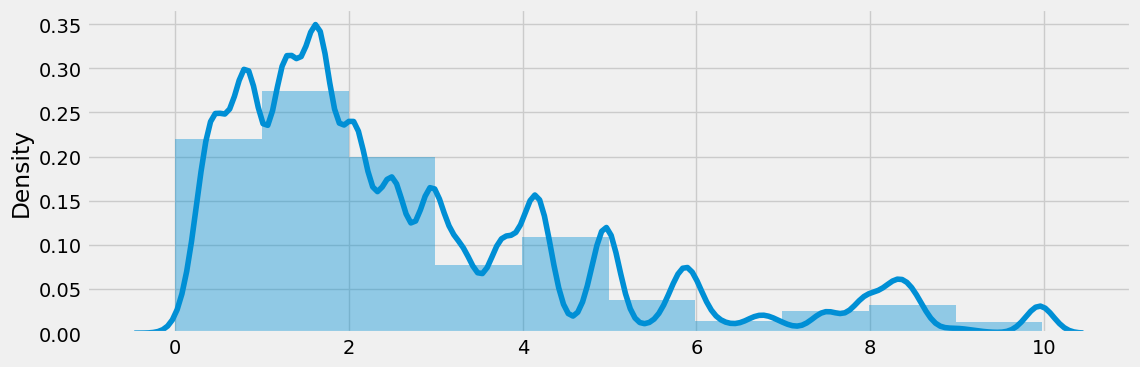

In [55]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)

<Axes: ylabel='Density'>

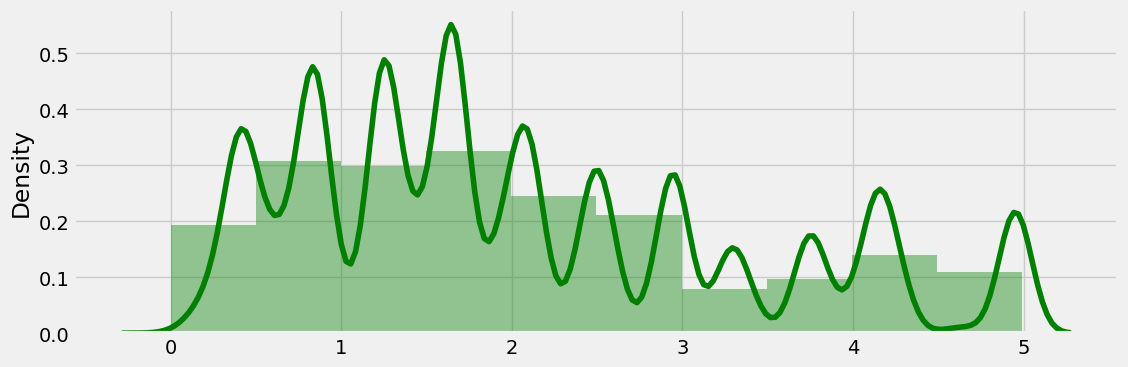

In [56]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 5]['UnitPrice'].values, kde=True, bins=10, color='green')

- From these histograms, I can see that the vast majority of items sold in this store have a low price range - 0 to 3 pounds.

<Axes: xlabel='Quantity', ylabel='Density'>

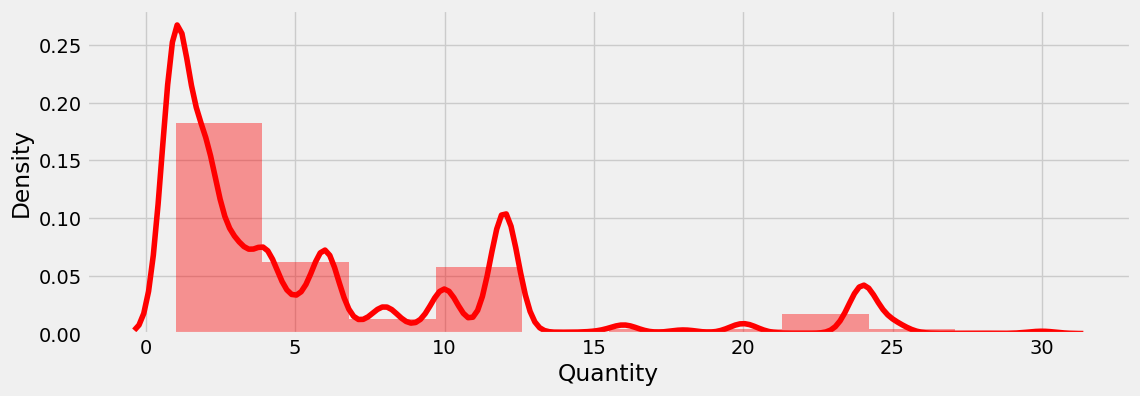

In [57]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')

<Axes: xlabel='Quantity', ylabel='Density'>

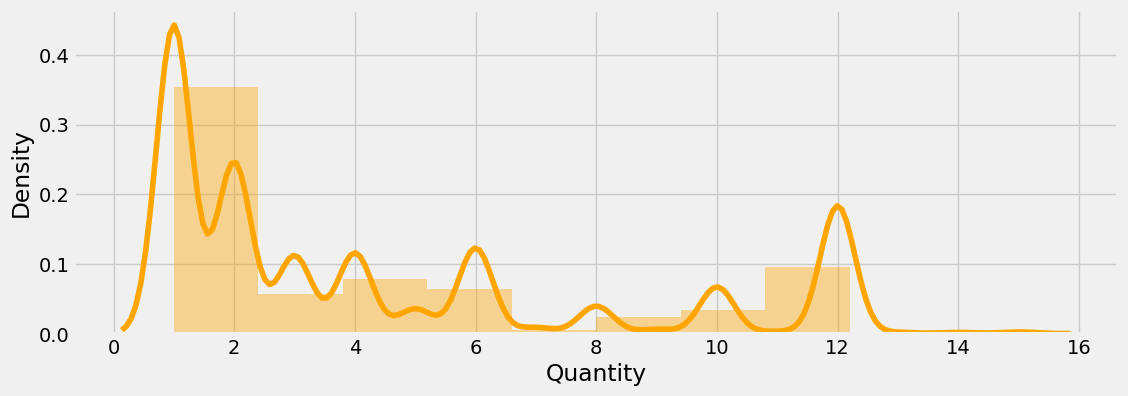

In [58]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 15]['Quantity'], kde=True, bins=10, color='orange')

- From these histograms I see that people bought normally 1-5 items or 10-12
- Maybe there was some kind of offers for sets?

<Axes: xlabel='UnitPrice', ylabel='Density'>

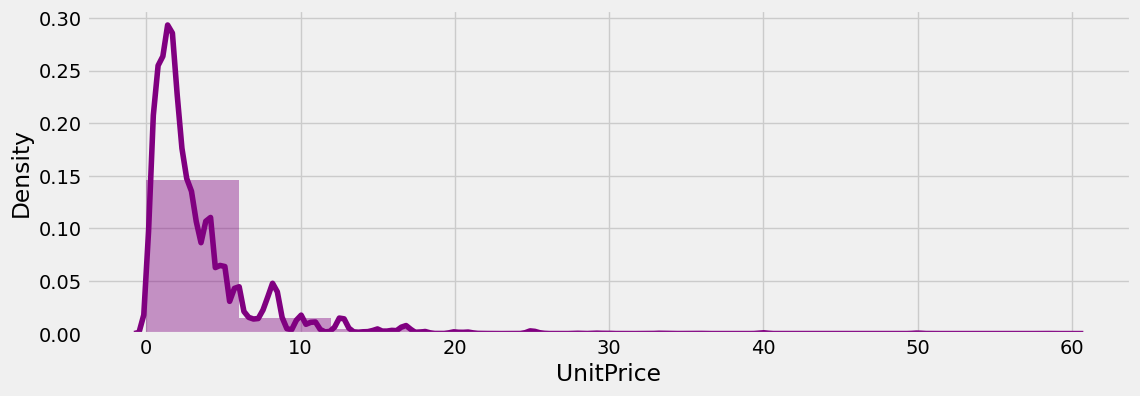

In [59]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 60]['UnitPrice'], kde=True, bins=10, color='purple')

<Axes: xlabel='UnitPrice', ylabel='Density'>

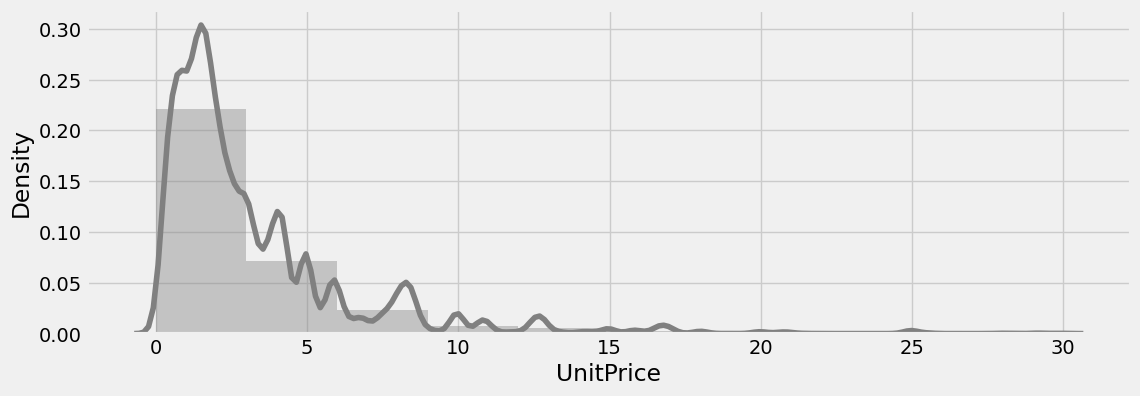

In [60]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 30]['UnitPrice'], kde=True, bins=10, color='grey')

- From these histograms, I can understand that majority of sales per order were in the range 1-15 pounds each.

## Analysing sales over time

In [61]:
df_ts = df[['UnitPrice']]
df_ts.head()

,UnitPrice
InvoiceDate,
2010-12-01 08:26:00,2.55
2010-12-01 08:26:00,3.39
2010-12-01 08:26:00,2.75
2010-12-01 08:26:00,3.39
2010-12-01 08:26:00,3.39


- As I can see every invoice has its own timestamp (definitely based on the time the order was made).
- I can resample time data by, for example, weeks, and try to see if there are any patterns in our sales.

<Axes: xlabel='InvoiceDate'>

<Figure size 1800x600 with 0 Axes>

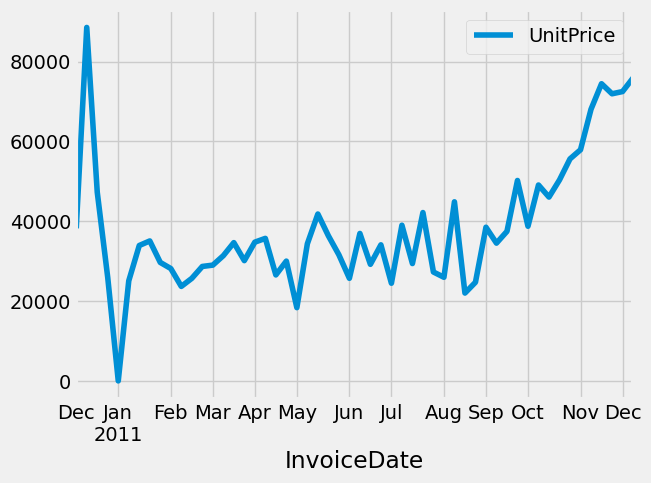

In [62]:
plt.figure(figsize=(18,6))
df_resample = df_ts.resample('W').sum()
df_resample.plot()

- That week with 0 sales in January looks suspicious, let's check it closer.

In [63]:
df_resample['12-2010':'01-2011']

,UnitPrice
InvoiceDate,
2010-12-05,38224.49
2010-12-12,88540.65
2010-12-19,47278.94
2010-12-26,25860.39
2011-01-02,0.00
2011-01-09,25072.03
2011-01-16,33919.09
2011-01-23,35064.34
2011-01-30,29676.45


- Now it makes sense - possibly, during the New Year holidays period the store was closed and didn't process orders, that's why they didn't make any sales.

## Preparing data for modeling and feature creation

In [64]:
df_clean = df[df['UnitPrice'] < 15]
df_clean.describe()

,Quantity,UnitPrice
count,520395.000000,520395.000000
mean,10.707578,2.978730
std,156.962876,2.669826
min,1.000000,0.001000
25%,1.000000,1.250000
50%,4.000000,2.080000
75%,12.000000,4.130000
max,80995.000000,14.960000


In [65]:
df_clean.index

DatetimeIndex(['2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:28:00',
               '2010-12-01 08:28:00', '2010-12-01 08:34:00',
               ...
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=520395, freq=None)

## Quantity per invoice feature
- A feature that could influence the sales output could be "Quantity per invoice". Let's find the data for this feature.

In [66]:
df_join = df_clean.groupby('InvoiceNo')[['Quantity']].sum()

In [67]:
df_join = df_join.reset_index()
df_join.head()

,InvoiceNo,Quantity
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3


In [68]:
df_clean['InvoiceDate'] = df_clean.index
df_clean = df_clean.merge(df_join, how='left', on='InvoiceNo')
df_clean = df_clean.rename(columns={'Quantity_x' : 'Quantity', 'Quantity_y' : 'QuantityInv'})
df_clean.tail(15)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv
520380,581587,22631,CIRCUS PARADE LUNCH BOX,12,1.95,France,2011-12-09 12:50:00,105
520381,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,France,2011-12-09 12:50:00,105
520382,581587,22555,PLASTERS IN TIN STRONGMAN,12,1.65,France,2011-12-09 12:50:00,105
520383,581587,22728,ALARM CLOCK BAKELIKE PINK,4,3.75,France,2011-12-09 12:50:00,105
520384,581587,22727,ALARM CLOCK BAKELIKE RED,4,3.75,France,2011-12-09 12:50:00,105
520385,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,3.75,France,2011-12-09 12:50:00,105
520386,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,3.75,France,2011-12-09 12:50:00,105
520387,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,1.95,France,2011-12-09 12:50:00,105
520388,581587,22629,SPACEBOY LUNCH BOX,12,1.95,France,2011-12-09 12:50:00,105
520389,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,4.15,France,2011-12-09 12:50:00,105


In [69]:
df_clean.describe()

,Quantity,UnitPrice,InvoiceDate,QuantityInv
count,520395.000000,520395.000000,520395,520395.000000
mean,10.707578,2.978730,2011-07-05 01:44:16.782867456,533.624937
min,1.000000,0.001000,2010-12-01 08:26:00,1.000000
25%,1.000000,1.250000,2011-03-28 13:28:00,152.000000
50%,4.000000,2.080000,2011-07-20 16:12:00,300.000000
75%,12.000000,4.130000,2011-10-19 13:58:00,567.000000
max,80995.000000,14.960000,2011-12-09 12:50:00,80995.000000
std,156.962876,2.669826,NaN,903.091973


In [70]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

In [71]:
df_clean.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
UnitPrice,float64
Country,object
InvoiceDate,datetime64[ns]
QuantityInv,int64


## Bucketing Quantity and UnitPrice features
- Based on the EDA done previously I can group these features into 6 buckets for Quantity and 5 for UnitePrice using the pandas.cut() method.

In [72]:
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)])
df_clean['QuantityRange'] = pd.cut(df_clean['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 20)])
df_clean['PriceRange'] = pd.cut(df_clean['UnitPrice'], bins=bins_p)
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv,QuantityRange,PriceRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"


## Extracting and bucketing dates
- I have noticed that depending on the season gifts sell differently:

    - pick of sales is in the Q4
    - then it drastically drops in Q1 of the next year
    - and continues to grow till its new pick in Q4 again.


- From this observation, I can create another feature that could improve the model.

In [73]:
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12


In [74]:
bins_d = pd.IntervalIndex.from_tuples([(0,3),(3,6),(6,9),(9,12)])
df_clean['DateRange'] = pd.cut(df_clean['Month'], bins=bins_d, labels=['q1','q2','q3','q4'])
df_clean.tail()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
520390,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,France,2011-12-09 12:50:00,105,"(11, 14]","(0, 1]",12,"(9, 12]"
520391,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,France,2011-12-09 12:50:00,105,"(5, 8]","(2, 3]",12,"(9, 12]"
520392,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,France,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520393,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,France,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520394,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,4.95,France,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"


## Building a model

## Splitting data into UK and non-UK
- I have to analyse these 2 datasets separately to have more standardised data for a model because there can be some patterns that work for other countries and do not for the UK or vice versa.
- Also a hypothesis to test - does the model built for the UK performs well on data for other countries?

In [75]:
df_uk = df_clean[df_clean['Country'] == 'United Kingdom']
df_abroad = df_clean[df_clean['Country'] != 'United Kingdom']

In [76]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"


## Extracting features and creating dummy variables

In [77]:
df_uk_model = df_uk[['UnitPrice', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange']]

In [78]:
df_uk_model.head()

,UnitPrice,QuantityInv,QuantityRange,PriceRange,DateRange
0,2.55,40,"(5, 8]","(2, 3]","(9, 12]"
1,3.39,40,"(5, 8]","(3, 4]","(9, 12]"
2,2.75,40,"(5, 8]","(2, 3]","(9, 12]"
3,3.39,40,"(5, 8]","(3, 4]","(9, 12]"
4,3.39,40,"(5, 8]","(3, 4]","(9, 12]"


In [79]:
df_data = df_uk_model.copy()
df_data = pd.get_dummies(df_data, columns=['QuantityRange'], prefix='qr')
df_data = pd.get_dummies(df_data, columns=['PriceRange'], prefix='pr')
df_data = pd.get_dummies(df_data, columns=['DateRange'], prefix='dr')
df_data.head()

,UnitPrice,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,2.55,40,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
1,3.39,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,2.75,40,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
3,3.39,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
4,3.39,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True


## Scaling
- As the majority of the features are in the 0-1 range it would make sense to scale the "QuantityInv" feature too.
- In general, scaling features is normally a good idea.

In [80]:
from sklearn.preprocessing import scale

df_data['QuantityInv'] = scale(df_data['QuantityInv'])

## Train-Test Split

In [81]:
y = df_data['UnitPrice']
X = df_data.drop(columns=['UnitPrice'])

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

## Testing and validating different models
- I use GridSearch and CrossValidation to test three types of regressors:
    - Linear
    - Decision Tree
    - RandomForest

In [83]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Linear Regression

In [84]:
fit_intercepts = [True, False]
param_grid_linear = dict(fit_intercept=fit_intercepts)
linear_model = LinearRegression()

## Decision Tree

In [85]:
min_tree_splits = range(2,3)
min_tree_leaves = range(2,3)
param_grid_tree = dict(min_samples_split=min_tree_splits,
                       min_samples_leaf=min_tree_leaves)
tree_model = DecisionTreeRegressor()

## Random Forest

In [86]:
estimators_space = [100]
min_sample_splits = range(2,4)
min_sample_leaves = range(2,3)
param_grid_forest = dict(min_samples_split=min_sample_splits,
                       min_samples_leaf=min_sample_leaves,
                       n_estimators=estimators_space)
forest_model = RandomForestRegressor()

## Testing and validating

In [89]:
cv = 3

models_to_test = ['LinearRegression','DecisionTreeRegressor','RandomForest']
regression_dict = dict(LinearRegression=linear_model,
                       DecisionTreeRegressor=tree_model,
                       RandomForest=forest_model)
param_grid_dict = dict(LinearRegression=param_grid_linear,
                       DecisionTreeRegressor=param_grid_tree,
                       RandomForest=param_grid_forest)

score_dict = {}
params_dict = {}
mae_dict = {}
mse_dict = {}
r2_dict = {}
best_est_dict = {}

for model in models_to_test:
  regressor = GridSearchCV(regression_dict[model], param_grid_dict[model], cv=cv, n_jobs=-1)

  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)

  # Print the tuned parameters and score
  print(" === Start report for regressor {} ===".format(model))
  score_dict[model] = regressor.best_score_
  print("Tuned Parameters: {}".format(regressor.best_params_))
  params_dict = regressor.best_params_
  print("Best score is {}".format(regressor.best_score_))

  # Compute metrics
  mae_dict[model] = mean_absolute_error(y_test, y_pred)
  print("MAE for {}".format(model))
  print(mean_absolute_error(y_test, y_pred))
  mse_dict[model] = mean_squared_error(y_test, y_pred)
  print("MSE for {}".format(model))
  print(mean_squared_error(y_test, y_pred))
  r2_dict[model] = r2_score(y_test, y_pred)
  print("R2 score for {}".format(model))
  print(r2_score(y_test, y_pred))
  print(" === End of report for regressor {} === \n".format(model))

  # Add best estimator to the dict
  best_est_dict[model] = regressor.best_estimator_

 === Start report for regressor LinearRegression ===
Tuned Parameters: {'fit_intercept': True}
Best score is 0.7539590728380515
MAE for LinearRegression
0.715311974025125
MSE for LinearRegression
1.7357713929975975
R2 score for LinearRegression
0.755062349421775
 === End of report for regressor LinearRegression === 

 === Start report for regressor DecisionTreeRegressor ===
Tuned Parameters: {'min_samples_leaf': 2, 'min_samples_split': 2}
Best score is 0.7515105228213552
MAE for DecisionTreeRegressor
0.6498866798350317
MSE for DecisionTreeRegressor
1.7034939368389284
R2 score for DecisionTreeRegressor
0.759617076104125
 === End of report for regressor DecisionTreeRegressor === 

 === Start report for regressor RandomForest ===
Tuned Parameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score is 0.7583588377976428
MAE for RandomForest
0.6468074246746811
MSE for RandomForest
1.674174136333263
R2 score for RandomForest
0.7637544429718194
 === End of report 

## Creating summary report

In [90]:
summary_cols = ['Best Score']
summary = pd.DataFrame.from_dict(r2_dict, orient='index')
summary.index.name = 'Regressor'
summary.columns = summary_cols
summary = summary.reset_index()

## Visualising results

<Axes: title={'center': 'Regressor Comparison'}, xlabel='Best score', ylabel='Regressor'>

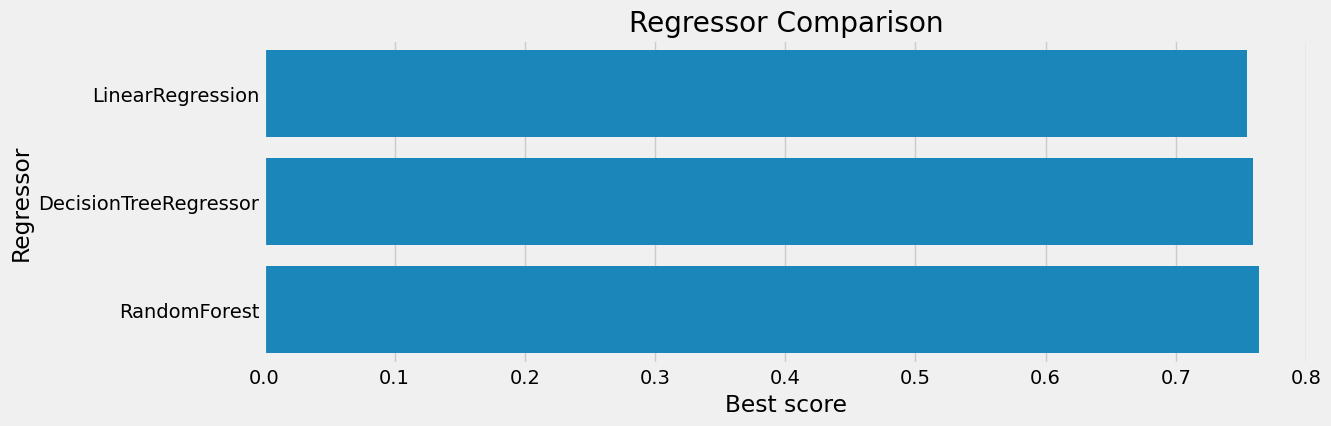

In [91]:
plt.figure(figsize=(12,4))
plt.xlabel('Best score')
plt.title('Regressor Comparison')

sns.barplot(x='Best Score', y='Regressor', data=summary)

## Conclusions
- This is a basic analysis of a transactions dataset with a model that predicts sales.

- Random Forest Regressor appears to be the best model for the prediction with an R2 score of more than 0.7 which is not that bad.